In [23]:
%pylab inline
import gzip

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


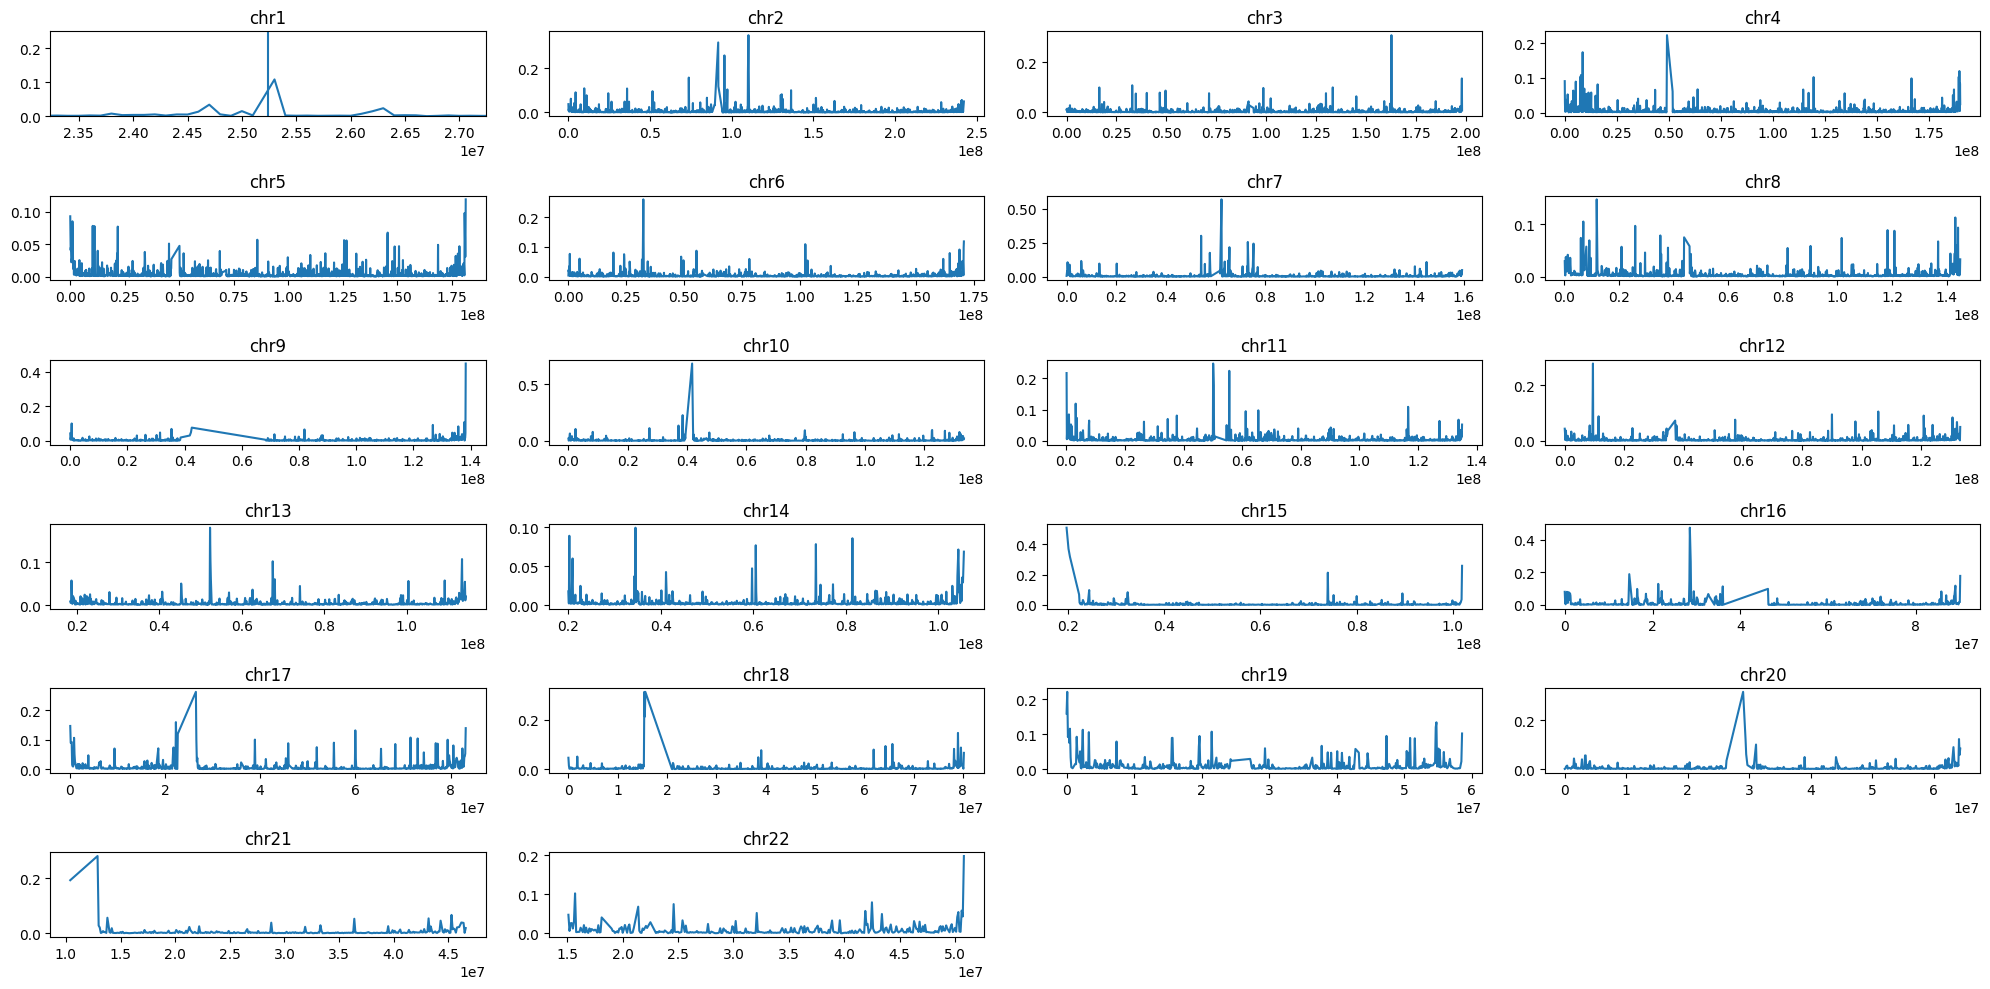

In [69]:
# TODO - normalize by local average
import pandas as pd
data = pd.read_csv("hprc-v1.1-mc-grch38_complexity_100000.tab.gz", sep="\t")
data = data[(data["numwalks"]>75) & (data["numwalks"]<100)]
fig = plt.figure()
fig.set_size_inches((20, 10))
pltnum = 1
for chrom in range(1, 23):
    ax = fig.add_subplot(6, 4, pltnum)
    df = data[data["chrom"]=="chr"+str(chrom)]
    ax.plot(df["start"], df["sequniq-normwalk"])
    ax.set_title("chr"+str(chrom))
    pltnum += 1
fig.tight_layout()

[(0.0, -0.4), (0.0, 0.0), (1000000.0, 0.0), (1000000.0, -0.4), (0, 0)]


TypeError: len() of unsized object

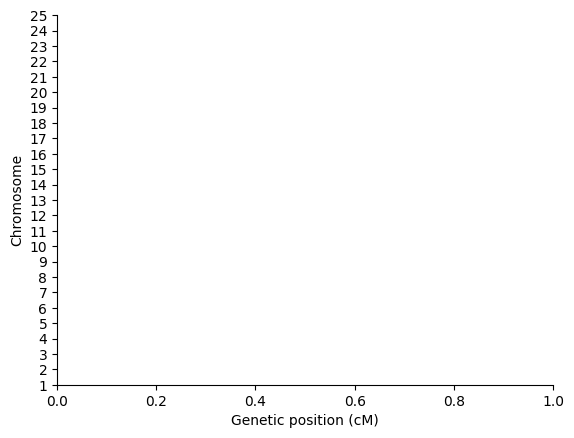

In [38]:
import os
import matplotlib

#matplotlib.use("Agg")
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.collections as mcol
import numpy as np
import os
import sys

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

PADDING = 0.4  # PADDING between chromosomes

def GetChrom(chrom):
    """
    Extract a numerical chromosome

    Parameters
    ----------
    chrom : str
       Chromosome string

    Returns
    -------
    chrom : int
       Integer-value for the chromosome
       X gets set to 23
    """
    if b"X" in chrom:
        return 23
    if b"Y" in chrom:
        return 24
    if b"M" in chrom:
        return 25
    if chrom.startswith(b"chr"):
        return int(chrom[3:])
    else:
        return int(chrom)

def GetChromOrder(blocks):
    """
    Get a list of chroms in sorted order

    Parameters
    ----------
    sample_blocks : list[list[hap_blocks]]
       each hap_block is a dictionary with keys
       'pop', 'chrom', 'start', 'end'

    Returns
    -------
    chroms : list[int]
       list of chromsomes in sorted order
    """
    chroms = set()
    for b in blocks:
        chroms.add(GetChrom(b["chrom"][3:]))
    chroms = list(chroms)
    chroms.sort()
    return chroms

def GetBlocks(bed_file):
    blocks = []
    with gzip.open(bed_file, "rb") as f:
        for line in f:
            if line.startswith(b"chrom"): continue
            items = line.strip().split(b"\t")
            score = items[6]
            try:
                score = float(score)
            except:
                continue
            b = {"chrom": items[0], "start": int(items[1]), "end": int(items[2]), "score": score}
            blocks.append(b)
    return blocks

PADDING = 0.4  # PADDING between chromosomes

def GetCmRange(blocks):
    """
    Get the min and max cM coordinates from the sample_blocks

    Parameters
    ----------
    sample_blocks : list[list[hap_blocks]]
       each hap_block is a dictionary with keys
       'pop', 'chrom', 'start', 'end'

    Returns
    -------
    min_val, max_val : float, float
       min_val is the minimum coordinate
       max_val is the maximum coordinate
    """
    min_val = np.inf
    max_val = -1 * np.inf
    for b in blocks:
        if b["start"] < min_val:
            min_val = b["start"]
        if b["end"] > max_val:
            max_val = b["end"]
    return min_val, max_val

def GetColor(score):
    return "gray"

def PlotKaryogram(bed_file, out_file, title=None):
    sample_blocks = GetBlocks(bed_file)
    min_cm, max_cm = GetCmRange(sample_blocks)
    chrom_order = GetChromOrder(sample_blocks)

    # Set up the figure for plotting
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel("Genetic position (cM)")
    ax.set_ylabel("Chromosome")
    if title is not None:
        ax.set_title(title)
    ax.set_yticks(range(len(chrom_order)))
    ax.set_yticklabels(chrom_order)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")

    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.CLOSEPOLY,
    ]
    
    for b in sample_blocks:
        chrom_coord = chrom_order.index(GetChrom(b["chrom"]))
        start = float(b["start"])
        stop = float(b["end"])

        hapnum=1
        verts = [
            (start, chrom_coord - hapnum * PADDING),
            (start, chrom_coord + (1 - hapnum) * PADDING),
            (stop, chrom_coord + (1 - hapnum) * PADDING),
            (stop, chrom_coord - hapnum * PADDING),
            (0, 0),
        ]
        clip_path = Path(verts, codes)
        print(verts)
        col = mcol.PathCollection([clip_path], GetColor(b["score"]), linewidths=0)
        ax.add_collection(col)

    # Make sure axis limits are wide enough
    ax.set_xlim(min_cm - 5, max_cm + 5)
    ax.set_ylim(len(chrom_order) + 3, -3)

    fig.savefig(out_file)

PlotKaryogram("hprc-v1.1-mc-grch38_complexity_1000000.tab.gz","out.png")